# Clasificación de Naive Bayes (Bayes Ingenua)

En las clases previas vimos conceptos y procesos de machine learning desde una perspectiva general.
A partir de esta clase veremos de cerca algoritmos específicos de aprendizaje supervisado y no supervisado, comenzando con clasificación de _Bayes Ingenua_ (_Naive Bayes_).

El grupo de modelos _Naive Bayes_ es _extremadamente_ rápido y simple, y es adecuado para datos de muchas dimensiones.
Como son tan rápidos y necesitan poca configuración, suelen ser usados como modelos "_peor-es-ná_", con resultados útiles que pueden ser utilizados como base.
En esta clase explicaremos cómo funciona la clasificación de Bayes Ingenua, y veremos un par de ejemplos de ella en acción.

## Clasificación Bayesiana

_Naive Bayes_ se construye sobre los métodos de clasificación bayesiana.
Se apoyan en el teorema de Bayes, una ecuación que describe la relación entre probabilidades condicionales de cantidades.

En clasificación estamos interesades en encontrar la probabilidad de que una etiqueta describa las características observadas, que podemos escribir como$P(E~|~{\rm características})$.
El teorema de Bayes nos dice cómo expresar esto en términos de cantidades que podemos estimar de manera más directa:

$$
P(E~|~{\rm características}) = \frac{P({\rm características}~|~E)P(E)}{P({\rm características})}
$$

Si queremos decidir entre dos etiquetas, que llamaremos $E_1$ y $E_2$, entonces una manera de tomar esta decisión es estimando el radio de las probabilidades posteriores de cada etiqueta:

$$
\frac{P(E_1~|~{\rm características})}{P(E_2~|~{\rm características})} = \frac{P({\rm características}~|~E_1)}{P({\rm características}~|~E_2)}\frac{P(E_1)}{P(E_2)}
$$

Lo que necesitamos entonces es algún modelo que estime $P({\rm características}~|~E_i)$ para cada etiqueta $E_i$.
Dichos modelos son llamados _generativos_ (_generative_) porque especifican el proceso aleatorio hipotético que genera los datos.
Encontrar el modelo generativo para cada etiqueta es la principal pieza del entrenamiento de un clasificador Bayesiano.
La versión general de ea tarea es muy difícil, pero podemos simplificarla asumiendo cosas sobre su forma y estrictura.

Esos supuestos simples son los que explican la "ingenuidad" en _Naive Bayes_: si usamos supuestos ingenuos sobre el modelo generativo de cada modelo, podremos encontrar una aproximación gruesa de los modelos generativos para cada clase, y luego proceder con la clasificación Bayesiana.
Distintos tipos de clasificadores de Bayes Ingenuos se basan en distintos supuestos sobre los datos. Eso veremos en la clase de hoy.

Comencemos con el preámbulo estándar:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Bayes Ingenuo Gaussiano (_Gaussian Naive Bayes_)

Quizás el clasificador de Bayes más sencillo de entender es el Gaussiano.
En este clasificador se asume que los datos de cada etiqueta se generan a través de una distribución Gaussiana simple.

Imagina que tienes los siguientes datos:

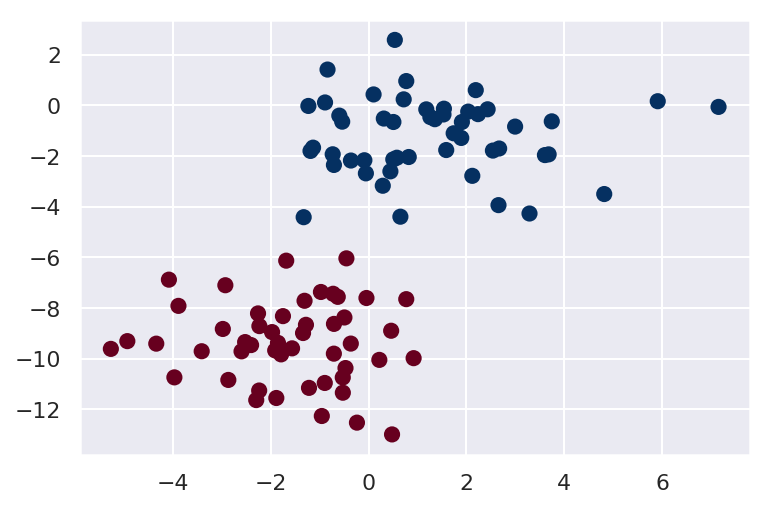

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Una manera rapidísima de crear un modelo simple es asumir que los datos se describen por distribuciones Gaussianas sin covarianza entre dimensiones.
Este modelo se puede ajustar simplemente encontrando el promedio y la desviación estándar de los puntos en cada etiqueta, que es lo único que necesitas para definir dichas distribuciones.
El resultado de este supuesto ingenuo se muestra en la siguiente imagen:

![(run code in Appendix to generate image)](figures/05.05-gaussian-NB.png)

Las elipses representan el modelo generativo Gaussiano para cada etiqueta, con una probabilidad mayor de pertenencia hacia el centro de las elipses.
Con este modelo generativo para cada clase, tenemos una receta simple para estimar la _likelihood_ $P({\rm característics}~|~E_1)$ para cualquier punto en el espacio bidimensional, y así, podremos comparar la relación entre las probabilidades posteriores y conocer la etiqueta más probable para el punto.

Este proceso está implementado en el estimador ``sklearn.naive_bayes.GaussianNB`` de Scikit-Learn:

In [3]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Generemos algunos datos para predecir sus etiquetas:

In [4]:
rng = np.random.RandomState(0)
# define un punto en la esquina (-6, -14) y luego generar dos mil puntos entre esa esquina y (14,18)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

In [17]:
ynew

array([1, 1, 1, ..., 0, 1, 1])

Podemos graficar estos datos para tener una idea de cuál es el borde de decisión del modelo:

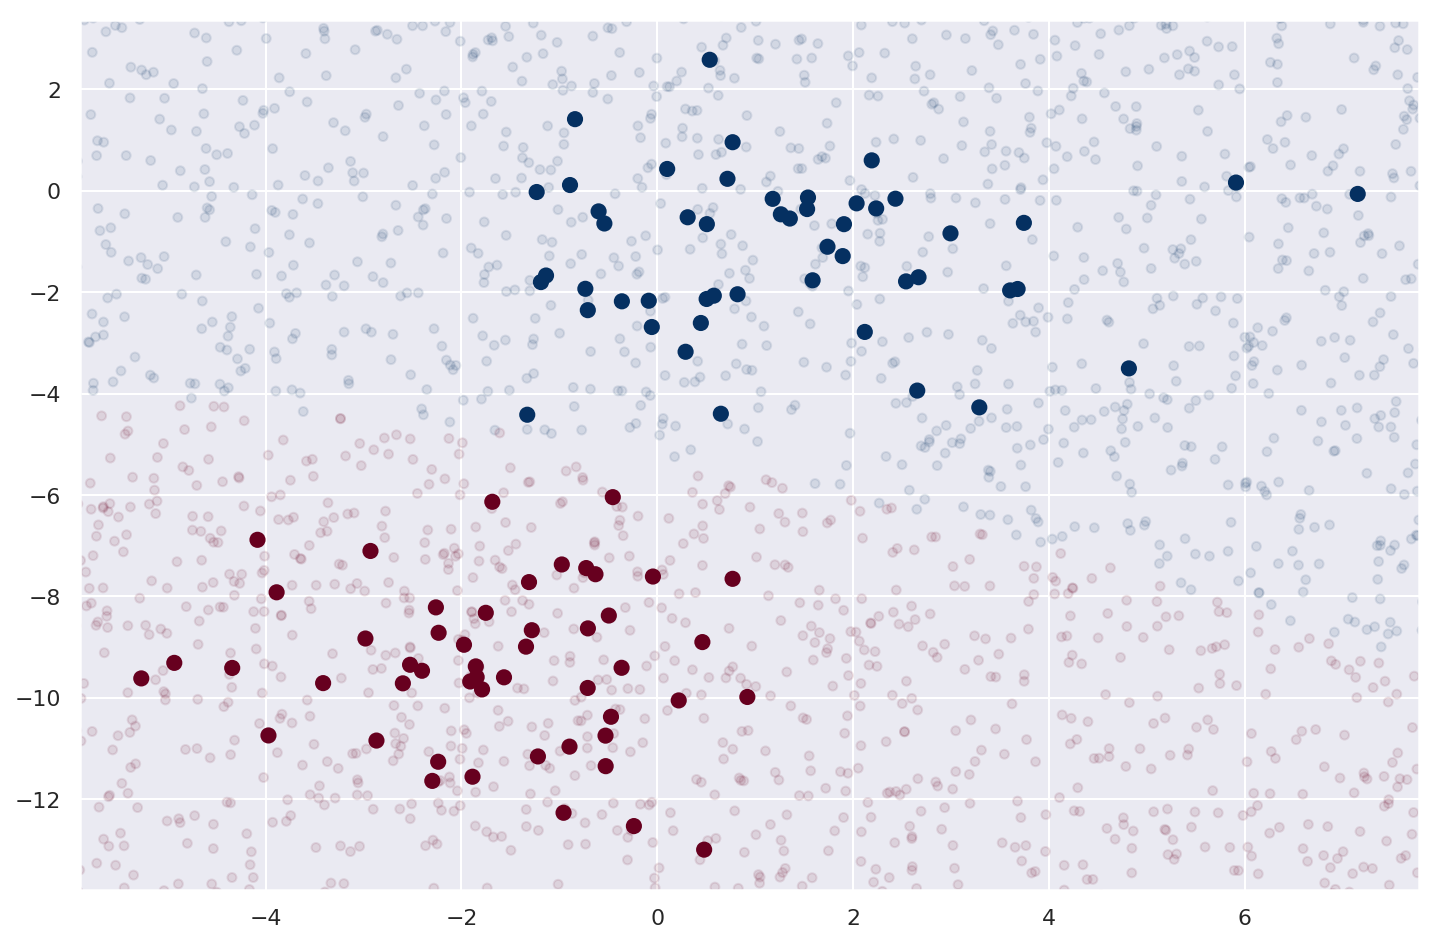

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

Vemos un borde ligeramente curvo. En general, el modelo Gaussiano genera bordes cuadráticos.

El formalismo Bayesiano permite extender la funcionalidad de los clasificadores, por ej., entregando las probabilidades posteriores de cada etiqueta, a través del método ``predict_proba``:

In [18]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

Cada columna de la matriz presenta las probabilidades de la etiqueta correspondiente.
Si necesitas calcular la certeza de la clasificación, los enfoques Bayesianos te permitirán hacerlo.

Claro, la clasificación final será tan buena como la correspondencia entre los datos y los supuestos del modelo, lo que explica por qué _Gaussian Naive Bayes_ no produce buenos resultados.
Aún así, en muchos casos, como cuando la cantidad de características es grande, este supuesto no es tan malo como para prevenir que el modelo sea útil.

## _Multinomial Naive Bayes_

Los supuestos Gaussianos no son los únicos que se pueden hacer, ni menos los únicos simples.
Otro ejemplo útil es _Multinomial Naive Bayes_, donde las características de los datos se suponen generadas por una distribución multinomial simple.
La distribución multinomial describe la probabilidad de observar conteos entre categorías, y por tanto, _Multinomial Naive Bayes_ es apropiado para características que describen conteos o tasas.

La idea es la misma de antes, excepto que en vez de modelar los datos como las Gaussianas que mejor se ajustan a los datos, lo hacemos con las multinomiales que mejor se ajustan.

### Ejemplo: Clasificando Texto

Un campo en el que Multinomial Naive Bayes se usa con frecuencia es en la clasificación de texto, donde las características de los datos son frecuencia de palabras en los documentos.
Discutimos la extracción de esas características en la clase pasada; aquí veremos la frecuencia de palabras de un corpus llamado _20 newsgroups_ para ver cómo podemos clasificar textos cortos en categorías.

Usaremos Scikit-Learn para cargar los datos y ver las etiquetas disponibles:

In [19]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Por simplicidad, trabajaremos con algunas categorías solamente, que podemos descargar diferenciadamente:

In [20]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Aquí hay una muestra de los datos:

In [21]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



Para usar estos datos en machine learning, necesitamos convertir los contenidos de cada texto en un vector de números.
Usaremos el vectorizador de _TF-IDF_, y crearemos una _pipeline_ en la que usaremos el Multinomial Naive Bayes:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Con este pipeline podemos aplicar el modelo a los datos de entrenamiento, y predecir etiquetas para los datos de entrenamiento:

In [28]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

In [29]:
labels

array([2, 0, 1, ..., 1, 2, 1])

Ahora procederemos a evaluar los resultados con una matriz de confusión:

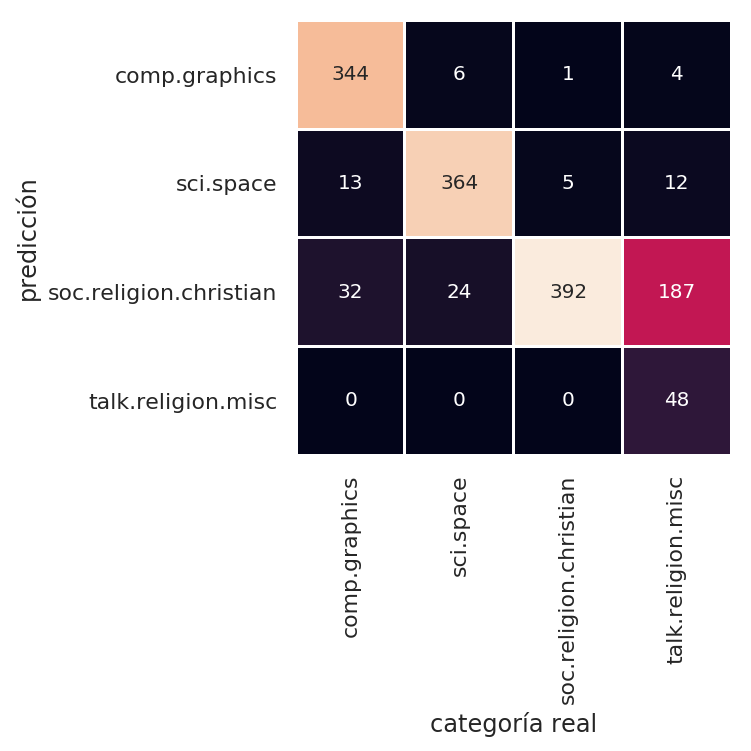

In [30]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, linewidth=1,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('categoría real')
plt.ylabel('predicción');

Evidentemente, este modelo tan simple puede separar sin problemas la conversación sobre el espacio de la conversación sobre gráfica de computadores, pero se confunde cuando habla de religión y cristianidad. Ahora bien, son dos categorías donde une podría esperar que haya confusión.

Lo genial de esto es que ahora podemos determinar la categoría de _cualquier_ texto, usando el método ``predict()`` de la _pipeline_.
Aquí hay una _funcióncita_ que entrega la predicción para un único texto:

In [31]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Probemos:

In [43]:
predict_category('rendering astronaut christ')

'soc.religion.christian'

In [44]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [48]:
predict_category('determining the screen resolution to watch a movie about christ')

'comp.graphics'

Recuerda que esto no es nada más que sofisticado que un modelo probabilístico simple para la frecuencia (ponderada) de cada palabra en el texto; aún así, el resultado es interesante. 
Incluso un algoritmo muy ingenuo, cuando ha sido usado con cuidado y entrenado en un set enorme de datos con muchas dimensiones, puede ser sorprendentemente efectivo.

## ¿Cuándo usar Naive Bayes?

Como los clasificadores de Naive Bayes asumen distribucions estrictias sobre los datos, generalmente no funcionarán tan bien como un modelo más complejo.
Sin embargo, tienen varias ventajas:

- Son muy rápidos, tanto para entrenar como para predecir.
- Proveen predicción de probabilidades.
- Son fáciles de interpretar.
- Tienen (si es que) pocos parámetros ajustables.

Estas ventajas significan que un modelo Bayesiano puede ser una buena elección para una base inicial de clasificación.
Si funciona bien, felicitaciones: tienes un modelo muy rápido, interpretable, para tu problema.
Si no funciona bien, entonces puedes comenzar a explorar modelos más complejos, teniendo claro cuál es el desempeño base que debe ser mejorado.

Estos clasificadores tienden a funcionar muy bien en las siguientes situaciones:

- Cuando los supuestos se corresponden con los datos (algo muy raro).
- Para categorías muy separadas, donde la complejidad del modelo es menos importante.
- Para datos con muchas dimensiones (categorías), donde la complejidad del modelo no es tan importante.

Estos dos últimos puntos parecen diferentes, pero en realidad se relacionan: a medida que crece la dimensión de un dataset, es menos probable que dos puntos cualesquiera se encuentren cerca (después de todo, deben estar cerca _en todas las dimensiones_ para estar cerca en general).
Esto significa que el clustering en altas dimensiones tiende a estar más separado, en promedio, que los _clusters_ en bajas dimensiones, asumiendo que las nuevas dimensiones añaden información. Por este motivo, clasificadores simplistas como Naive Bayes tienden a funcionar bien o incluso mejor que los clasificadores complejos a media que crece la dimensionalidad: una vez que tienes suficientes datos, incluso un modelo simple puede ser muy poderoso.

## Créditos

![](figures/PDSH-cover.png)

Este notebook contiene un extracto del libro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; el contenido también está disponible en [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

El texto se distribuye bajo una licencia [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), y el código se distribuye bajo la licencia [MIT](https://opensource.org/licenses/MIT). Si te parece que este contenido es útil, por favor considera apoyar el trabajo [comprando el libro](http://shop.oreilly.com/product/0636920034919.do).

Traducción al castellano por [Eduardo Graells-Garrido](http://datagramas.cl), liberada bajo las mismas condiciones.